# Installation

In [ ]:
pip install qiskit qiskit_ibm_runtime qiskit-ibmq-provider pylatexenc qiskit-aer

# Import and IBM account setup

In [ ]:
# General imports
import numpy as np
from qiskit import IBMQ, execute, Aer
from qiskit.opflow import StateFn

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp, Pauli, Statevector
from qiskit.circuit import QuantumCircuit, Parameter

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService,  Session, Options
from qiskit.primitives import Estimator
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt
import networkx as nx
from qiskit.transpiler import TranspileLayout
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram
import random
from itertools import chain
from qiskit.circuit.library import TwoLocal

<ipython-input-3-a44afea5ce2c>:4: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import StateFn


In [ ]:
from google.colab import userdata
IBMProvider.save_account(userdata.get('ibm_api_key'))

In [ ]:
# Setup account and backend service
provider = IBMProvider()
service = QiskitRuntimeService()


# Implementation Starts here

In [ ]:
# Computing the weight matrix from the random graph
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [ ]:
def draw_circuit(qc:QuantumCircuit):
  qc.draw(output='mpl',style='clifford')

In [ ]:
def add_hwe_ansatz(qc:QuantumCircuit, repetation_count=2)->QuantumCircuit:
  n = qc.num_qubits
  theta, phi = Parameter('theta'), Parameter('phi')

  for _ in range(repetation_count):
    for i in range(n):
      qc.rx(theta,i)
      qc.ry(phi,i)

    for i in range(n-1):
      qc.cx(i, i+1)

In [ ]:
def add_hwe_ansatz2(qc:QuantumCircuit, repetation_count=2)->QuantumCircuit:
  n = qc.num_qubits
  theta, phi = Parameter('theta'), Parameter('phi')
  params = [[Parameter(f"param_{i}_0"), Parameter(f"param_{i}_1")] for i in range(n)]

  for _ in range(repetation_count):
    for i in range(n):
      qc.rx(params[i][0],i)
      qc.ry(params[i][1],i)

    for i in range(n-1):
      qc.cx(i, i+1)

In [ ]:
def add_ry_ansatz(qc:QuantumCircuit, repetation_count=2)->QuantumCircuit:
  n = qc.num_qubits
  theta= Parameter('theta')

  for i in range(n):
    qc.ry(theta,i)

In [ ]:
def identity_pauli_string(n):
    return ["I" for _ in range(n)]

In [ ]:
def get_pauli_strings_from_graph(sparse_graph_list,n):
  pauli_strings = []
  for (x,y,w) in sparse_graph_list:
    temp_pauli_string_arr = identity_pauli_string(n)
    temp_pauli_string_arr[x] = temp_pauli_string_arr[y] = "Z"
    pauli_strings.append("".join(temp_pauli_string_arr))

  return pauli_strings

In [ ]:
def generate_random_param_values(num_params):
  return [random.uniform(-2*np.pi,2*np.pi) for _ in range(num_params)];

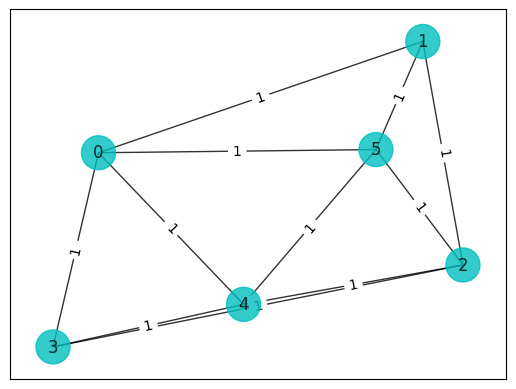

In [ ]:
# Defining a graph
n = 6
# list_edges = [[0,1],[1,2],[2,5],
#               [0,3],[1,5],[3,4],
#               [0,4],[2,3],[4,5],
#               [0,5],[2,5]]

list_edges = [[0,1],[0,3],[0,4],[0,5],[1,2],[1,5],[2,3],[2,4],[2,5],[3,4],[4,5]]

# n=5
# list_edges = [
#     [0,1],
#     [0,2],
#     [1,2],
#     [1,4],
#     [2,3],
#     [3,4]
# ]
elist = [(x,y,1) for x,y in list_edges]
# n=4
# elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]


G = nx.Graph()
G.add_weighted_edges_from(elist)
colors = ["c" for i in range(n)]
draw_graph(G, colors, nx.spring_layout(G))
plt.show()


In [ ]:
# ansatz_qc = QuantumCircuit(n,name='Hardware Efficient Ansatz')
ansatz_qc = TwoLocal(6, "ry", "cz", reps=5, entanglement="linear")
ansatz_qc = ansatz_qc.decompose()
# ansatz_qc = EfficientSU2(n);
# add_hwe_ansatz(ansatz_qc)
num_params = ansatz_qc.num_parameters
pauli_strings = list(set(get_pauli_strings_from_graph(elist,n)))
pauli_strings.sort()
print(pauli_strings)
ansatz_arr = [ansatz_qc.copy(name=p) for p in pauli_strings] #ansatz circuit corresponding to each pauli string
hamiltonian_arr = SparsePauliOp.from_list([(p,0.5) for p in pauli_strings]) #observable corresponding to each pauli string
print(hamiltonian_arr.to_matrix())
# ansatz_qc.draw(output='mpl',style='clifford')
np.diag(hamiltonian_arr.to_matrix())

['IIIIZZ', 'IIIZZI', 'IIZIIZ', 'IIZIZI', 'IIZZII', 'IZIIIZ', 'IZZIII', 'ZIIIIZ', 'ZIIIZI', 'ZIIZII', 'ZZIIII']
[[5.5+0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 1.5+0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 1.5+0.j ... 0. +0.j 0. +0.j 0. +0.j]
 ...
 [0. +0.j 0. +0.j 0. +0.j ... 1.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 1.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 5.5+0.j]]


array([ 5.5+0.j,  1.5+0.j,  1.5+0.j, -0.5+0.j,  2.5+0.j, -1.5+0.j,
        0.5+0.j, -1.5+0.j,  1.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
        0.5+0.j, -1.5+0.j,  0.5+0.j,  0.5+0.j,  2.5+0.j,  0.5+0.j,
       -1.5+0.j, -1.5+0.j, -0.5+0.j, -2.5+0.j, -2.5+0.j, -2.5+0.j,
        0.5+0.j,  0.5+0.j, -1.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j,
       -0.5+0.j,  1.5+0.j,  1.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
        0.5+0.j, -1.5+0.j,  0.5+0.j,  0.5+0.j, -2.5+0.j, -2.5+0.j,
       -2.5+0.j, -0.5+0.j, -1.5+0.j, -1.5+0.j,  0.5+0.j,  2.5+0.j,
        0.5+0.j,  0.5+0.j, -1.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j,
       -0.5+0.j,  1.5+0.j, -1.5+0.j,  0.5+0.j, -1.5+0.j,  2.5+0.j,
       -0.5+0.j,  1.5+0.j,  1.5+0.j,  5.5+0.j])

# Cost Function

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator, intermediate_data, num_params,print_debug_info=False):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Flattened Array of ansatz parameters
        ansatz (QuantumCircuit): Array of Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        intermediate_data (Dict): mutable object to store intermediate data
        num_params (int): Number of parameters in circuit
        print_debug_info (Boolean): Whether to print each iteration's information (False by default)
    Returns:
        float: Energy estimate
    """

    # perform cost calculation
    energy = sum(estimator.run(ansatz, hamiltonian, parameter_values=params).result().values)

    # update data for analysis
    intermediate_data["params_history"].append(params)
    intermediate_data['iters']+=1
    intermediate_data["cost_history"].append(energy)
    if(print_debug_info):
      print("Iters. done: {}, Params: {}, Current cost: {}".format(intermediate_data["iters"],params, energy))
    return energy

# **Classic Brute Force Calculation**

case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 1, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 0, 0] cost = 5.0
case = [0, 0, 1, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 0, 0] cost = 7.0
case = [0, 1, 1, 0, 0, 0] cost = 4.0
case = [1, 1, 1, 0, 0, 0] cost = 6.0
case = [0, 0, 0, 1, 0, 0] cost = 3.0
case = [1, 0, 0, 1, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0] cost = 6.0
case = [1, 1, 0, 1, 0, 0] cost = 6.0
case = [0, 0, 1, 1, 0, 0] cost = 4.0
case = [1, 0, 1, 1, 0, 0] cost = 6.0
case = [0, 1, 1, 1, 0, 0] cost = 5.0
case = [1, 1, 1, 1, 0, 0] cost = 5.0
case = [0, 0, 0, 0, 1, 0] cost = 3.0
case = [1, 0, 0, 0, 1, 0] cost = 5.0
case = [0, 1, 0, 0, 1, 0] cost = 6.0
case = [1, 1, 0, 0, 1, 0] cost = 6.0
case = [0, 0, 1, 0, 1, 0] cost = 6.0
case = [1, 0, 1, 0, 1, 0] cost = 8.0
case = [0, 1, 1, 0, 1, 0] cost = 7.0
case = [1, 1, 1, 0, 1, 0] cost = 7.0
case = [0, 0, 0, 1, 1, 0] cost = 4.0
case = [1, 0, 0, 1, 1, 0] cost = 4.0
case = [0, 1, 0, 1, 1, 0] cost = 7.0
c

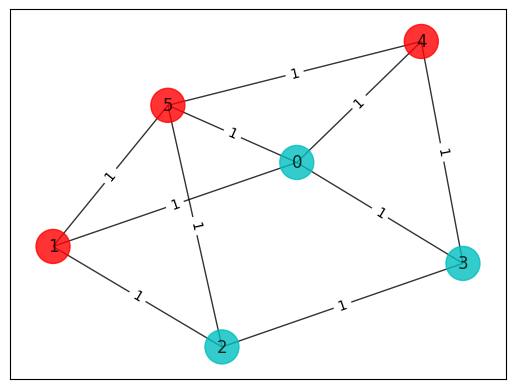

In [ ]:
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, nx.spring_layout(G))
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

# Using **ibmq_qasm_simulator**

In [ ]:
# Code to run on ibm-runtime-simulator
options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 100000

intermediate_data = {
  "params_history": [],
  "iters": 0,
  "cost_history": [],
}

with Session(backend="qasm_simulator") as session:
  estimator = Estimator()
  res = minimize(
      fun=cost_func,
      x0=generate_random_param_values(num_params),
      args=(ansatz_arr, hamiltonian_arr, estimator,intermediate_data,num_params),
      method="cobyla",
  )

print('\nintermediate_data [#iterations: {} , cost: {}, params:{}]'.format(intermediate_data['iters'],intermediate_data['cost_history'][-1],intermediate_data['params_history'][-1]))
print('res',res)


intermediate_data [#iterations: 48 , cost: 1.999999960449355, params:[3.14151357e+00 1.83798963e-05]]
res  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.999999960449355
       x: [ 3.142e+00  1.838e-05]
    nfev: 48
   maxcv: 0.0


# **Using Aer Simulator backend**

In [ ]:
from qiskit import Aer, QuantumCircuit, transpile, assemble
from qiskit_aer.primitives import Estimator as AerEstimator

intermediate_data = {
  "params_history": [],
  "iters": 0,
  "cost_history": [],
}
# print(hamiltonian_arr)


with Session(backend=Aer.get_backend('aer_simulator')) as session:
  estimator = AerEstimator(run_options={'shots':100000})
  res = minimize(
      fun=cost_func,
      x0=generate_random_param_values(num_params),
      args=(ansatz_qc, hamiltonian_arr, estimator,intermediate_data,num_params,True),
      method="cobyla",
  )

print('\nintermediate_data [#iterations: {} , cost: {}, params:{}]'.format(intermediate_data['iters'],intermediate_data['cost_history'][-1],intermediate_data['params_history'][-1]))
print('res',res)


# Using final parameters to get the state vector

optimal parameters [ 7.25106361 -0.255374   -0.5397968  -4.35567399 -0.75338239  1.91348577
  5.51056833 -0.26052467 -4.71107429 -1.19541864 -4.46047647 -4.15467949
  5.28125528  0.106809   -5.12989533  3.06225742  3.19320257 -3.50934653
  3.19369484 -1.79592119  5.14579624  0.06281429 -4.65715029 -1.92237287
 -5.1218053   0.46445159 -3.24812907 -1.0823573   1.93710752  0.07773892
 -2.00300482 -5.14849905 -5.54603907  6.21601885 -2.30311759 -5.65821394]


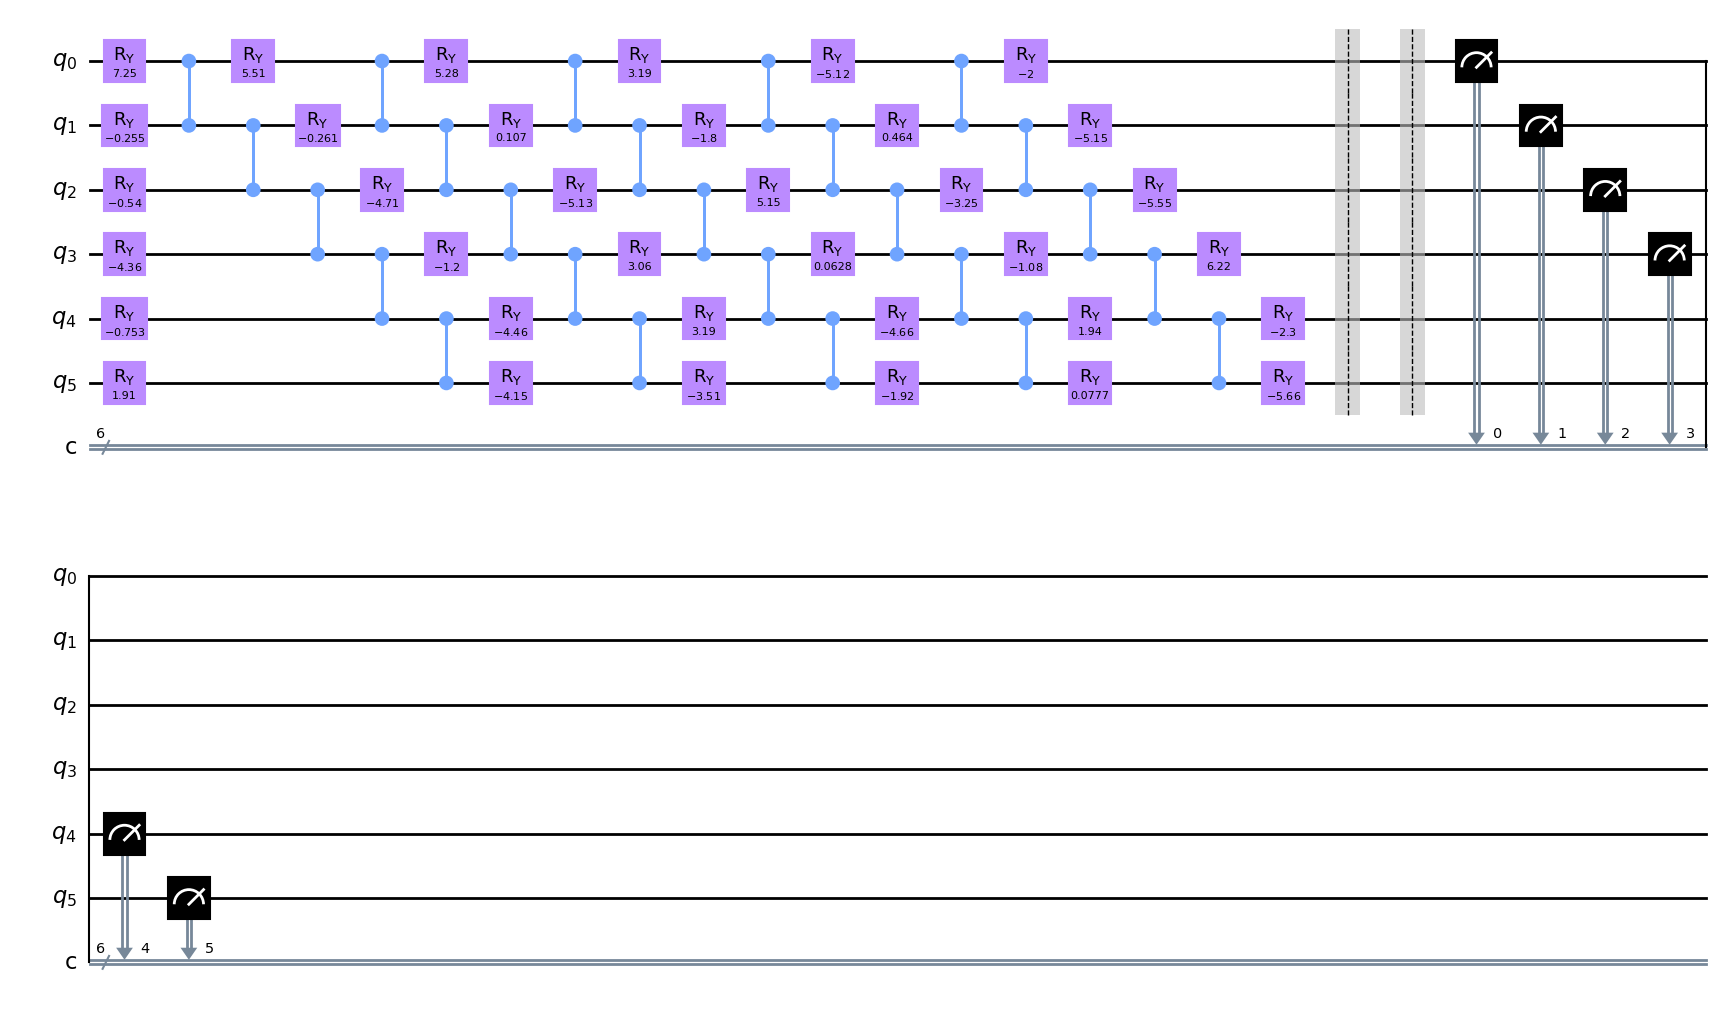

In [ ]:
# Use Aer simulator backend
aer_backend = Aer.get_backend('aer_simulator')

from qiskit.visualization import plot_state_city

print('optimal parameters',intermediate_data['params_history'][-1])

# Transpile the circuit for the simulator
t_ansatz_qc = QuantumCircuit(n,n)
t_ansatz_qc.compose(ansatz_qc,inplace=True)
t_ansatz_qc = t_ansatz_qc.assign_parameters(intermediate_data['params_history'][-1])
t_ansatz_qc.barrier()
t_ansatz_qc.measure_all(add_bits=False)


backend = service.get_backend('simulator_mps')
result = aer_backend.run(t_ansatz_qc,shots=10000).result()

# Get the final state
final_state = result.get_counts()

t_ansatz_qc.draw(output='mpl',style='clifford')

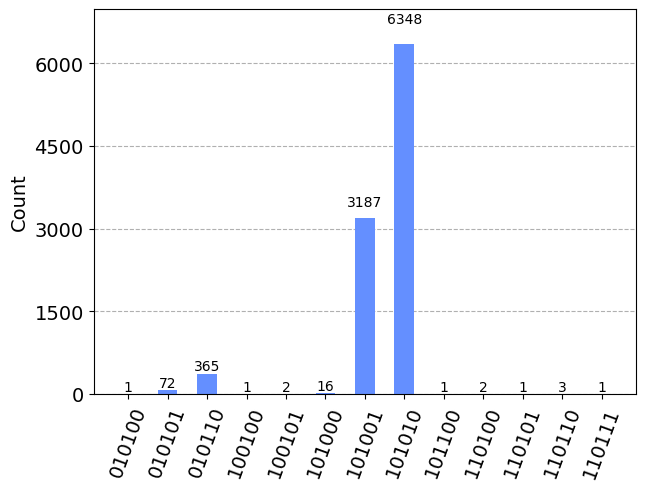

In [ ]:
plot_histogram(final_state)

# Visualizing Parameters and convergence
We can also now view the progress towards convergence as monitored by the cost history at each iteration:


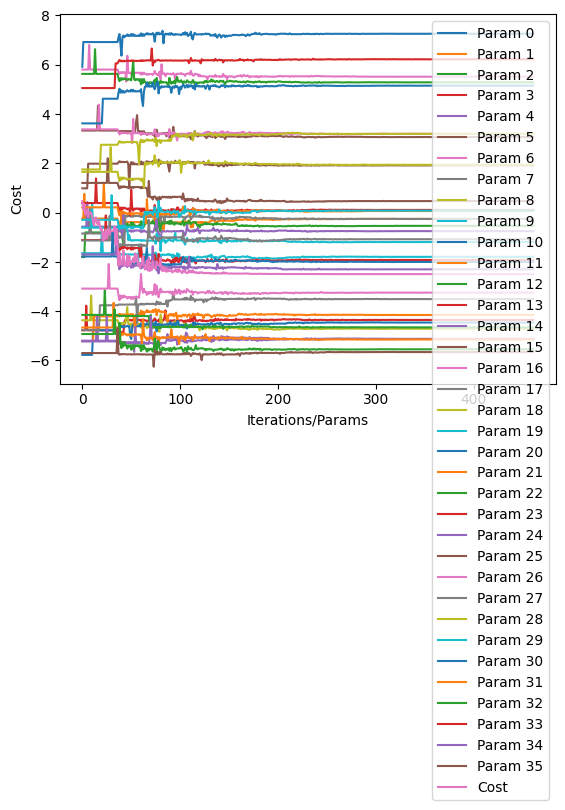

In [ ]:
fig, ax = plt.subplots()
# Extracting parameter value history from the 2D array using zip(*two_d_array)
transposed_array = list(zip(*intermediate_data['params_history']))
column_lists = [list(column) for column in transposed_array]

for i,p in enumerate(column_lists):
  ax.plot(p,label='Param {}'.format(i))

ax.plot(range(intermediate_data['iters']), intermediate_data['cost_history'],label='Cost')
ax.set_xlabel("Iterations/Params")
ax.set_ylabel("Cost")
plt.legend()
plt.draw()